# Calculate 12-Month Climatology for intpp-hist & Decadal Climatologies for intpp-ssp585

#Andrea Fassbender
#10/17/2019

In [2]:
%matplotlib inline

import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

In [3]:
# Load Historical Data Files

ds_lon = xr.open_dataset('Data/ds_lon.nc')
ds_lat = xr.open_dataset('Data/ds_lat.nc')
hist = xr.open_dataset('Data/hist_intpp_mask.nc')
ds_hist = hist.squeeze()
#ds_hist_oa = xr.open_dataset('Data/hist_oa_mask.nc')

#note: to merge datasets into array
#hist = xr.merge([ds_hist_oa.squeeze(), ds_hist.squeeze()])

In [4]:
ds_hist

<xarray.Dataset>
Dimensions:    (nlat: 384, nlon: 320, time: 1980)
Coordinates:
    member_id  <U8 'r1i1p1f1'
  * nlat       (nlat) int32 1 2 3 4 5 6 7 8 ... 377 378 379 380 381 382 383 384
  * nlon       (nlon) int32 1 2 3 4 5 6 7 8 ... 313 314 315 316 317 318 319 320
  * time       (time) object 1850-01-15 13:00:00 ... 2014-12-15 12:00:00
Data variables:
    intpp      (time, nlat, nlon) float32 ...

# Historical 12-Month Climatolgoy

In [5]:
#Calculate climatologies and StDevs
clim_m_hist = ds_hist.groupby('time.month').mean('time')
clim_std_hist = ds_hist.groupby('time.month').std('time')
clim_m_hist

/ncar/usr/jupyterhub/envs/cmip6-201910a/lib/python3.7/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


<xarray.Dataset>
Dimensions:    (month: 12, nlat: 384, nlon: 320)
Coordinates:
    member_id  <U8 'r1i1p1f1'
  * nlon       (nlon) int32 1 2 3 4 5 6 7 8 ... 313 314 315 316 317 318 319 320
  * nlat       (nlat) int32 1 2 3 4 5 6 7 8 ... 377 378 379 380 381 382 383 384
  * month      (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    intpp      (month, nlat, nlon) float32 nan nan nan nan ... nan nan nan nan

In [6]:
# Load Riley's function (Hilary sent me this via slack direct message)
# note: the function operates in the order of the variable indices in the dataset, and thus returns 
# lat/lon, even though you enter your inputs as lon/lat
def find_indices(xgrid, ygrid, xpoint, ypoint):
   """Returns the i, j index for a latitude/longitude point on a grid.
   .. note::
       Longitude and latitude points (``xpoint``/``ypoint``) should be in the same
       range as the grid itself (e.g., if the longitude grid is 0-360, should be
       200 instead of -160).
   Args:
       xgrid (array_like): Longitude meshgrid (shape M, N)
       ygrid (array_like): Latitude meshgrid (shape M, N)
       xpoint (int or double): Longitude of point searching for on grid.
       ypoint (int or double): Latitude of point searching for on grid.
   Returns:
       i, j (int):
           Keys for the inputted grid that lead to the lat/lon point the user is
           seeking.
   Examples:
       >>> import esmtools as et
       >>> import numpy as np
       >>> x = np.linspace(0, 360, 37)
       >>> y = np.linspace(-90, 90, 19)
       >>> xx, yy = np.meshgrid(x, y)
       >>> xp = 20
       >>> yp = -20
       >>> i, j = et.spatial.find_indices(xx, yy, xp, yp)
       >>> print(xx[i, j])
       20.0
       >>> print(yy[i, j])
       -20.0
   """
   dx = xgrid - xpoint
   dy = ygrid - ypoint
   reduced_grid = abs(dx) + abs(dy)
   min_ix = np.nanargmin(reduced_grid)
   i, j = np.unravel_index(min_ix, reduced_grid.shape)
   return i, j

Text(0.5, 1.0, 'Location Comparisons')

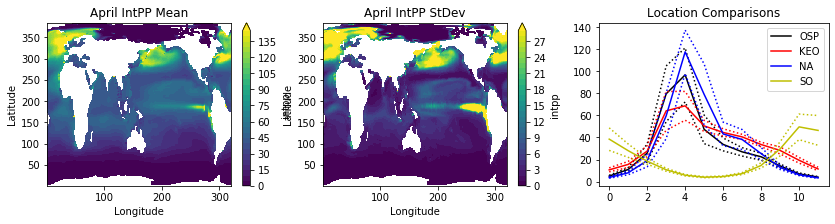

In [7]:
#historical

fig = plt.figure(figsize=(14, 3))

# Irregular levels to illustrate the use of a proportional colorbar
levels = np.arange(0, 150, 5)
levels2 = np.arange(0, 30, 1)

ax = fig.add_subplot(1, 3, 1)
(clim_m_hist.intpp*(10**8)).isel(month=4).plot(levels=levels)
ax.set_ylabel('Latitude')
ax.set_xlabel('Longitude')
plt.title('April IntPP Mean')

ax = fig.add_subplot(1, 3, 2)
(clim_std_hist.intpp*(10**8)).isel(month=4).plot(levels=levels2)
ax.set_ylabel('Latitude')
ax.set_xlabel('Longitude')
plt.title('April IntPP StDev')

# Identify indecies associated with osp, keo ,and NA
[a,b]=find_indices(ds_lon.lon, ds_lat.lat, 360-145, 50)
[a2,b2]=find_indices(ds_lon.lon, ds_lat.lat, 144.6, 32.4)
[a3,b3]=find_indices(ds_lon.lon, ds_lat.lat, 360-47.2, 50)
[a4,b4]=find_indices(ds_lon.lon, ds_lat.lat, 100, -45)

ax = fig.add_subplot(1, 3, 3)
var = clim_m_hist.intpp.isel(nlon=b,nlat=a)*10**8
var2 = clim_m_hist.intpp.isel(nlon=b2,nlat=a2)*10**8
var3 = clim_m_hist.intpp.isel(nlon=b3,nlat=a3)*10**8
var4 = clim_m_hist.intpp.isel(nlon=b4,nlat=a4)*10**8

#var_st = hist.clim_std[:, a, b].squeeze()*10**8
# #the above code (vs the below) is a way to remove the member dimesion and selec
#for all times at the a and b indices for lat/lon using slice
var_st = clim_std_hist.intpp.isel(nlon=b,nlat=a)*10**8
var2_st = clim_std_hist.intpp.isel(nlon=b2,nlat=a2)*10**8
var3_st = clim_std_hist.intpp.isel(nlon=b3,nlat=a3)*10**8
var4_st = clim_std_hist.intpp.isel(nlon=b4,nlat=a4)*10**8

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels)

plt.plot(var,'k',label='OSP')
plt.plot(var+var_st,':k')
plt.plot(var-var_st,':k')
plt.plot(var2,'r',label='KEO')
plt.plot(var2+var2_st,':r')
plt.plot(var2-var2_st,':r')
plt.plot(var3,'b',label='NA')
plt.plot(var3+var3_st,':b')
plt.plot(var3-var3_st,':b')
plt.plot(var4,'y',label='SO')
plt.plot(var4+var4_st,':y')
plt.plot(var4-var4_st,':y')
plt.legend()
plt.title('Location Comparisons')

# SSP585 Decadal Climatologies

In [8]:
# Load SSP585 Data Files
#ds_85_oa = xr.open_dataset('Data/ssp585_oa_mask.nc')
ssp85 = xr.open_dataset('Data/ssp585_intpp_mask.nc')
ds_85 = ssp85.squeeze()
#ds_85.squeeze().intpp
#ds_85.squeeze().intpp.isel(time=3).plot()

In [9]:
ds_85

<xarray.Dataset>
Dimensions:    (nlat: 384, nlon: 320, time: 1032)
Coordinates:
    member_id  <U8 'r1i1p1f1'
  * nlat       (nlat) int32 1 2 3 4 5 6 7 8 ... 377 378 379 380 381 382 383 384
  * nlon       (nlon) int32 1 2 3 4 5 6 7 8 ... 313 314 315 316 317 318 319 320
  * time       (time) object 2015-01-15 13:00:00 ... 2100-12-15 12:00:00
Data variables:
    intpp      (time, nlat, nlon) float32 ...

In [10]:
# # Create xarrays to save mean and stdev climatologies into (else you get arrays with no coordainte info...)

# # Create string of years bounding decades to loop through
# dlist = np.arange(2020,2100,10)

# # Pre-allocate: length of dlist = number of decades; 12 = months in climatology; lat/lon from ds_85
# pre = np.zeros((len(dlist), 12, ds_85.intpp.shape[1], ds_85.intpp.shape[2])) * np.nan
# times = pd.date_range(start=2025,end=2195,periods=len(dlist))

# # Create empty data arrays
# #clim_m_85 = xr.DataArray(pre, coords=[times, np.arange(1,13), ds_85.nlat, ds_85.nlon], dims=['time','month', 'lat', 'lon'])
# #clim_std_85  = xr.DataArray(pre, coords=[times, np.arange(1,13), ds_85.nlat, ds_85.nlon], dims=['time','month', 'lat', 'lon'])

In [11]:
# Calculate cliamtolgoies for each decade #OMG...we're doing it!!!

# Create string of years bounding decades to loop through
dlist = np.arange(2020,2100,10)
times = pd.date_range(start=2025,end=2195,periods=len(dlist))

# Start the loop. note, using enumerate allows you to link i to the index (0,1,2) and t to the values of dlist
for i, t in enumerate(dlist):
    print(str(t)+'-01-01', str(t+9)+'-12-31')
    ds_85_sub = ds_85.sel(time=slice(str(t)+'-01-01', str(t+9)+'-12-31'))
    m_85_sub = ds_85_sub.groupby('time.month').mean('time')
    std_85_sub = ds_85_sub.groupby('time.month').std('time')
    if i == 0:
        clim_m_85 = m_85_sub
        clim_std_85 = std_85_sub
    else:
        clim_m_85 = xr.concat([clim_m_85, m_85_sub],dim='time')
        clim_std_85 = xr.concat([clim_std_85, std_85_sub],dim='time')
clim_m_85['time'] = xr.DataArray((dlist), dims=['time'])
clim_std_85['time'] = xr.DataArray((dlist), dims=['time'])
    
    
#     clim_m_85[i,:,:,:] = m_85_sub
#     clim_std_85[i,:,:,:] = std_85_sub
    
    

2020-01-01 2029-12-31


/ncar/usr/jupyterhub/envs/cmip6-201910a/lib/python3.7/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


2030-01-01 2039-12-31
2040-01-01 2049-12-31
2050-01-01 2059-12-31
2060-01-01 2069-12-31
2070-01-01 2079-12-31
2080-01-01 2089-12-31
2090-01-01 2099-12-31


In [12]:
type(clim_m_85)
clim_std_85
#len(d_clim[:,1,1,1])

<xarray.Dataset>
Dimensions:    (month: 12, nlat: 384, nlon: 320, time: 8)
Coordinates:
    member_id  <U8 'r1i1p1f1'
  * month      (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
  * nlon       (nlon) int32 1 2 3 4 5 6 7 8 ... 313 314 315 316 317 318 319 320
  * nlat       (nlat) int32 1 2 3 4 5 6 7 8 ... 377 378 379 380 381 382 383 384
  * time       (time) int64 2020 2030 2040 2050 2060 2070 2080 2090
Data variables:
    intpp      (time, month, nlat, nlon) float32 nan nan nan nan ... nan nan nan

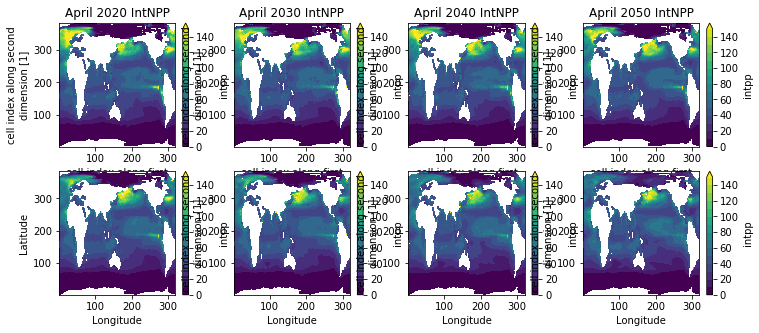

In [13]:
# plot ot make sure things worked

fig = plt.figure(figsize=(12, 5))
#set colorbar intervals
levels = np.arange(0, 160, 10)

for i in range(clim_m_85.intpp.shape[0]):
    ax = fig.add_subplot(2, 4, i+1)
    #plt.plot(d_clim[i,5,:,:]*(10**8))
    (clim_m_85.intpp*(10**8)).isel(time=i,month=4).plot(levels=levels)
    
    if i == 4:
        ax.set_ylabel('Latitude')
    elif i==4:
        ax.set_ylabel('Latitude')
    if i<4:
        plt.title('April ' + str(dlist[i]) + ' IntNPP')
    elif i>3:
        ax.set_xlabel('Longitude')
        plt.title('')

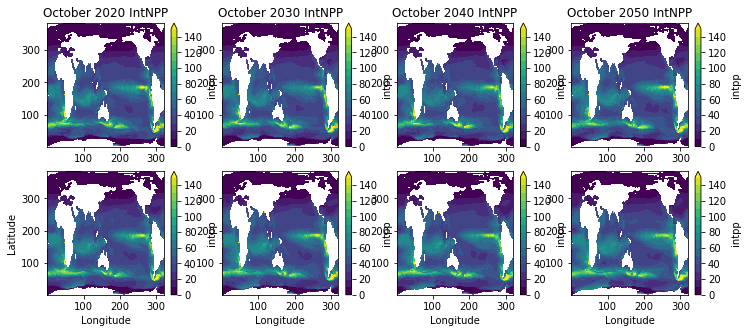

In [14]:
# plot ot make sure things worked

fig = plt.figure(figsize=(12, 5))
#set colorbar intervals
levels = np.arange(0, 160, 10)

for i in range(clim_m_85.intpp.shape[0]):
    ax = fig.add_subplot(2, 4, i+1)
    #plt.plot(d_clim[i,10,:,:]*(10**8))
    (clim_m_85.intpp*(10**8)).isel(time=i,month=10).plot(levels=levels)
    
    ax.set_ylabel('')
    ax.set_xlabel('')
    if i == 4:
        ax.set_ylabel('Latitude')
    elif i==4:
        ax.set_ylabel('Latitude')
    if i<4:
        plt.title('October ' + str(dlist[i]) + ' IntNPP')
    elif i>3:
        ax.set_xlabel('Longitude')
        plt.title('')

## Make figs above  for delta(IntPP) (ssp585-hist) by decade (may + oct)

In [15]:
clim_m_85
clim_m_hist
var =  clim_m_85.isel(time=i,month=5).squeeze() - clim_m_hist.intpp.isel(month=5).squeeze()  
var.intpp.squeeze()

<xarray.DataArray 'intpp' (nlat: 384, nlon: 320)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [ 0.,  0.,  0., ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)
Coordinates:
    member_id  <U8 'r1i1p1f1'
    month      int64 6
  * nlon       (nlon) int32 1 2 3 4 5 6 7 8 ... 313 314 315 316 317 318 319 320
  * nlat       (nlat) int32 1 2 3 4 5 6 7 8 ... 377 378 379 380 381 382 383 384
    time       int64 2090

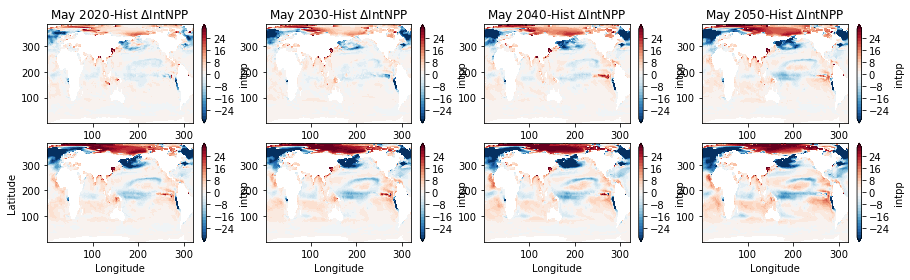

In [16]:
# Plot results

fig = plt.figure(figsize=(15, 4))

#set colorbar intervals
levels = np.arange(-30,32, 2)

for i in range(clim_m_85.intpp.shape[0]):
    ax = fig.add_subplot(2, 4, i+1)
    
    # Decadal climatology minus historical
    var =  clim_m_85.isel(time=i,month=5).squeeze() - clim_m_hist.intpp.isel(month=5).squeeze() 
    (var.intpp*(10**8)).plot(levels=levels)
    
    ax.set_ylabel('')
    ax.set_xlabel('')
    if i == 4:
        ax.set_ylabel('Latitude')
    elif i==4:
        ax.set_ylabel('Latitude')
    if i<4:
        plt.title('May ' + str(dlist[i]) + '-Hist $\Delta$IntNPP')
    elif i>3:
        ax.set_xlabel('Longitude')
        plt.title('')

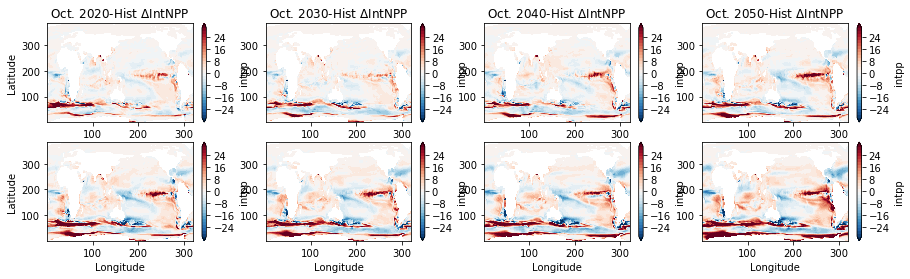

In [17]:
# Plot results

fig = plt.figure(figsize=(15, 4))

#set colorbar intervals
levels = np.arange(-30,32, 2)

for i in range(clim_m_85.intpp.shape[0]):
    ax = fig.add_subplot(2, 4, i+1)
    
    # Decadal climatology minus historical
    var =  clim_m_85.isel(time=i,month=10).squeeze() - clim_m_hist.intpp.isel(month=10).squeeze() 
    (var.intpp*(10**8)).plot(levels=levels)
    
    ax.set_ylabel('')
    ax.set_xlabel('')
    if i == 0:
        ax.set_ylabel('Latitude')
    elif i==4:
        ax.set_ylabel('Latitude')
    if i<4:
        plt.title('Oct. ' + str(dlist[i]) + '-Hist $\Delta$IntNPP')
    elif i>3:
        ax.set_xlabel('Longitude')
        plt.title('')

## Look at Specific Locations

/ncar/usr/jupyterhub/envs/cmip6-201910a/lib/python3.7/site-packages/ipykernel_launcher.py:71: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/ncar/usr/jupyterhub/envs/cmip6-201910a/lib/python3.7/site-packages/ipykernel_launcher.py:81: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/ncar/usr/jupyterhub/envs/cmip6-201910a/lib/python3.7/site-packages/ipykernel_launcher.py:91: MatplotlibDeprecationWarning: Adding an axes using the same ar

Text(0, 0.5, 'mol m-2 s-1')

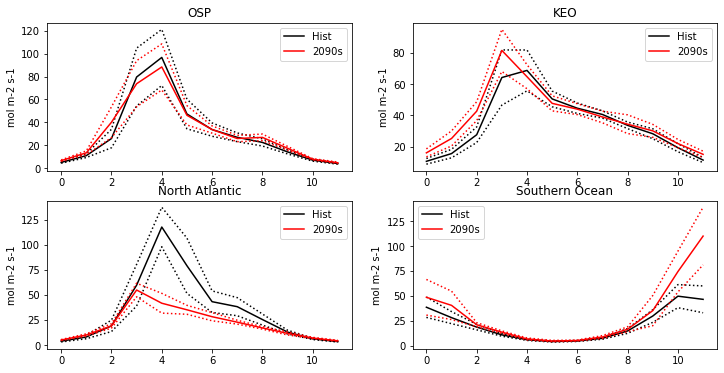

In [20]:
fig = plt.figure(figsize=(12, 6))

# Identify indecies associated with osp, keo, NA, and SO
[a,b]=find_indices(ds_lon.lon, ds_lat.lat, 360-145, 50)#OSP
[a2,b2]=find_indices(ds_lon.lon, ds_lat.lat, 144.6, 32.4)#KEO
[a3,b3]=find_indices(ds_lon.lon, ds_lat.lat, 360-47.2, 50)#NA
[a4,b4]=find_indices(ds_lon.lon, ds_lat.lat, 100, -45)#SO

var = clim_m_hist.intpp.isel(nlon=b,nlat=a)*10**8
var2 = clim_m_hist.intpp.isel(nlon=b2,nlat=a2)*10**8
var3 = clim_m_hist.intpp.isel(nlon=b3,nlat=a3)*10**8
var4 = clim_m_hist.intpp.isel(nlon=b4,nlat=a4)*10**8

var_st = clim_std_hist.intpp.isel(nlon=b,nlat=a)*10**8
var2_st = clim_std_hist.intpp.isel(nlon=b2,nlat=a2)*10**8
var3_st = clim_std_hist.intpp.isel(nlon=b3,nlat=a3)*10**8
var4_st = clim_std_hist.intpp.isel(nlon=b4,nlat=a4)*10**8

ax = fig.add_subplot(2,2,1)
plt.plot(var,'k',label='Hist')
plt.plot(var+var_st,':k')
plt.plot(var-var_st,':k')
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels)
plt.legend()
plt.title('OSP')
plt.ylabel('mol m-2 s-1')

ax = fig.add_subplot(2,2,2)
plt.plot(var2,'k',label='Hist')
plt.plot(var2+var2_st,':k')
plt.plot(var2-var2_st,':k')
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels)
plt.legend()
plt.title('KEO')
plt.ylabel('mol m-2 s-1')

ax = fig.add_subplot(2,2,3)
plt.plot(var3,'k',label='Hist')
plt.plot(var3+var3_st,':k')
plt.plot(var3-var3_st,':k')
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels)
plt.legend()
plt.title('North Atlantic')
plt.ylabel('mol m-2 s-1')

ax = fig.add_subplot(2,2,4)
plt.plot(var4,'k',label='Hist')
plt.plot(var4+var4_st,':k')
plt.plot(var4-var4_st,':k')
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels)
plt.legend()
plt.title('Southern Ocean')
plt.ylabel('mol m-2 s-1')

var = clim_m_85.intpp.isel(time=7,nlon=b,nlat=a)*10**8
var2 = clim_m_85.intpp.isel(time=7,nlon=b2,nlat=a2)*10**8
var3 = clim_m_85.intpp.isel(time=7,nlon=b3,nlat=a3)*10**8
var4 = clim_m_85.intpp.isel(time=7,nlon=b4,nlat=a4)*10**8

var_st = clim_std_85.intpp.isel(time=7,nlon=b,nlat=a)*10**8
var2_st = clim_std_85.intpp.isel(time=7,nlon=b2,nlat=a2)*10**8
var3_st = clim_std_85.intpp.isel(time=7,nlon=b3,nlat=a3)*10**8
var4_st = clim_std_85.intpp.isel(time=7,nlon=b4,nlat=a4)*10**8


ax = fig.add_subplot(2,2,1)
plt.plot(var,'r',label='2090s')
plt.plot(var+var_st,':r')
plt.plot(var-var_st,':r')
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels)
plt.legend()
plt.title('OSP')
plt.ylabel('mol m-2 s-1')

ax = fig.add_subplot(2,2,2)
plt.plot(var2,'r',label='2090s')
plt.plot(var2+var2_st,':r')
plt.plot(var2-var2_st,':r')
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels)
plt.legend()
plt.title('KEO')
plt.ylabel('mol m-2 s-1')

ax = fig.add_subplot(2,2,3)
plt.plot(var3,'r',label='2090s')
plt.plot(var3+var3_st,':r')
plt.plot(var3-var3_st,':r')
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels)
plt.legend()
plt.title('North Atlantic')
plt.ylabel('mol m-2 s-1')

ax = fig.add_subplot(2,2,4)
plt.plot(var4,'r',label='2090s')
plt.plot(var4+var4_st,':r')
plt.plot(var4-var4_st,':r')
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels)
plt.legend()
plt.title('Southern Ocean')
plt.ylabel('mol m-2 s-1')